In [ ]:
from pathlib import Path
import requests

    1. Path and request module are used for fetching data from src.
    2. The data is a zip file which contains the MNIST dataset in
       pickle format.
    3. Pickle format is used for serializing data(binary stream)
       objects in python.

In [ ]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir( parents=True, exist_ok = True )

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():

    content = requests.get(URL+FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

Here we use gzip and pickle module to unzip and access the dataset.

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(),"rb") as f:
        ((x_train,y_train) ,(x_valid,y_valid),_) = pickle.load(f,
            encoding= "latin-1")


    1. The dataset are pixels of images but they are stored as a
       flattened single vector or array with 784(28*28) columns or
       entries. 
    2. Inorder to plot the image we need to reshape it to 2D.
    3. There are 50,000 images or instances.

(50000, 784)


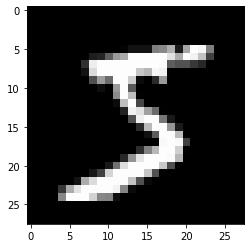

In [ ]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape(28,28),cmap = "gray")
print(x_train.shape)

1. PyTorch works on torch.tensor data-objects but our data is an
   array. Hence we need to construct tensor object from our dataset.
2. Torch.tensor is a module which does this,  hence we use map and
   (tensor module & corresponding array objects) to replace the array
   storing variables with tensor objects. 

In [ ]:
import torch

x_train , Y_train , x_valid , y_valid = map(
        torch.tensor , (x_train,y_train,x_valid,y_valid)
)
n,c = x_train.shape

print(x_train,y_train)
print(x_train.shape)
print(y_train.min(),y_train.max())

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1b0fc471-afe9-40dd-afe8-89e46e68c6e6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>